In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
%matplotlib inline
warnings.filterwarnings('ignore')
data = pd.read_csv("/content/2015_Air_quality_in_northern_Taiwan.csv", parse_dates=['time'])


In [ ]:
# We want to predict PM2.5, so we delete the rows with NA in 'PM2.5'
data = data[data['PM2.5'].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215768 entries, 0 to 218639
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        215768 non-null  datetime64[ns]
 1   station     215768 non-null  object        
 2   AMB_TEMP    198538 non-null  object        
 3   CH4         95104 non-null   object        
 4   CO          215577 non-null  object        
 5   NMHC        94927 non-null   object        
 6   NO          215509 non-null  object        
 7   NO2         215102 non-null  object        
 8   NOx         215510 non-null  object        
 9   O3          198280 non-null  object        
 10  PH_RAIN     34202 non-null   object        
 11  PM10        215561 non-null  object        
 12  PM2.5       215768 non-null  object        
 13  RAINFALL    207268 non-null  object        
 14  RAIN_COND   34202 non-null   object        
 15  RH          198612 non-null  object        
 16  SO2    

In [5]:
(data.isna().sum() / len(data)).sort_values(ascending=False)

UVB           0.881202
RAIN_COND     0.841886
PH_RAIN       0.841886
NMHC          0.562683
CH4           0.561732
THC           0.561727
WS_HR         0.166347
WIND_DIREC    0.165551
WIND_SPEED    0.165409
WD_HR         0.164325
O3            0.085872
AMB_TEMP      0.084477
RH            0.084138
RAINFALL      0.044187
PM10          0.013168
PM2.5         0.013136
NO2           0.008960
SO2           0.007286
NO            0.006458
NOx           0.006454
CO            0.006078
station       0.000000
time          0.000000
dtype: float64

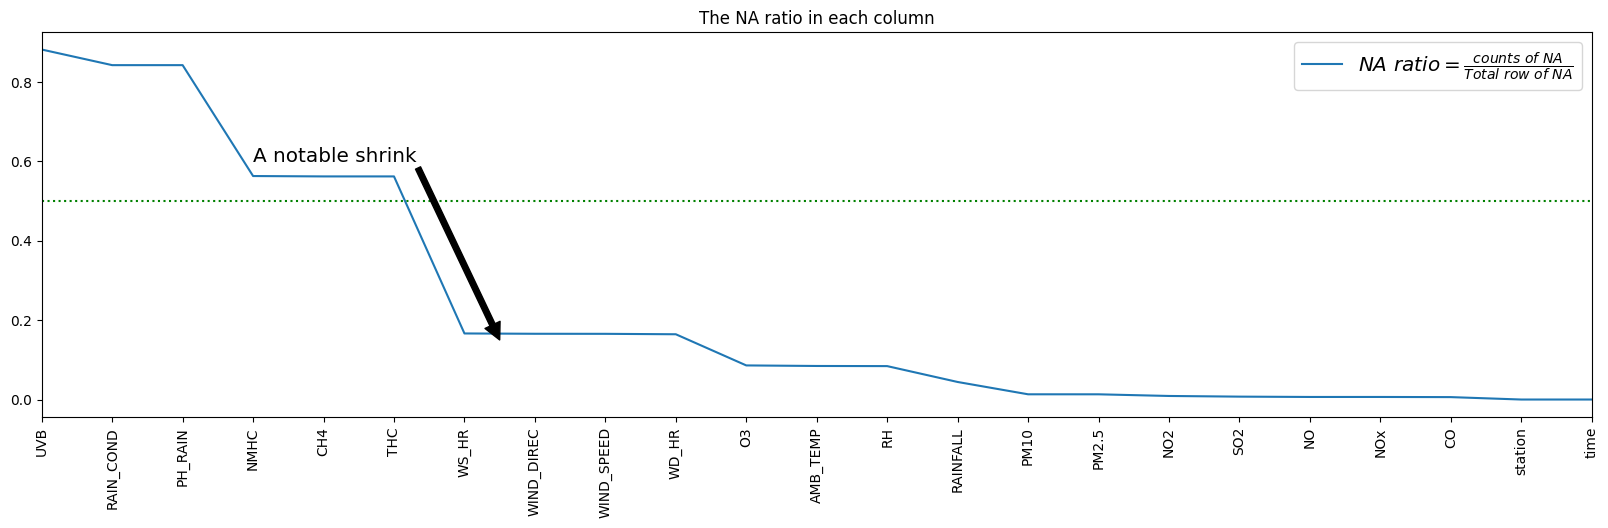

In [6]:
plt.figure(figsize=(20,5))
plt.title('The NA ratio in each column')
plt.xticks(rotation='vertical')
plt.plot([0,22],[0.5,0.5],'g:')
plt.plot((data.isna().sum() / len(data)).sort_values(ascending=False).index,
         (data.isna().sum() / len(data)).sort_values(ascending=False).values,'-',label=r'$NA \ ratio = \frac{counts \ of \ NA}{Total \ row \ of \ NA}$')
plt.annotate('A notable shrink', xy=(6.5, 0.15), xytext=(3, 0.6),fontsize='x-large',
            arrowprops={'facecolor':'black','shrink':1.0}
            )
plt.xlim(0,22)
_ = plt.legend(fontsize='x-large')

In [7]:
data['UVB'].value_counts()

UVB
0       13516
0.1      1082
0.2       597
0.3       540
0.4       464
        ...  
3.9#        1
5.3#        1
0.5#        1
13          1
0.3         1
Name: count, Length: 156, dtype: int64

In [8]:
data.drop(['UVB','RAIN_COND','PH_RAIN'],axis=1,inplace=True)

In [9]:
data[data['CO'].isna()].head()

,time,station,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
466,2015-01-20 10:00:00,Banqiao,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,40,NR,55,NaN,NaN,67,68,4,3
1097,2015-02-15 17:00:00,Banqiao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1098,2015-02-15 18:00:00,Banqiao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1099,2015-02-15 19:00:00,Banqiao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1100,2015-02-15 20:00:00,Banqiao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


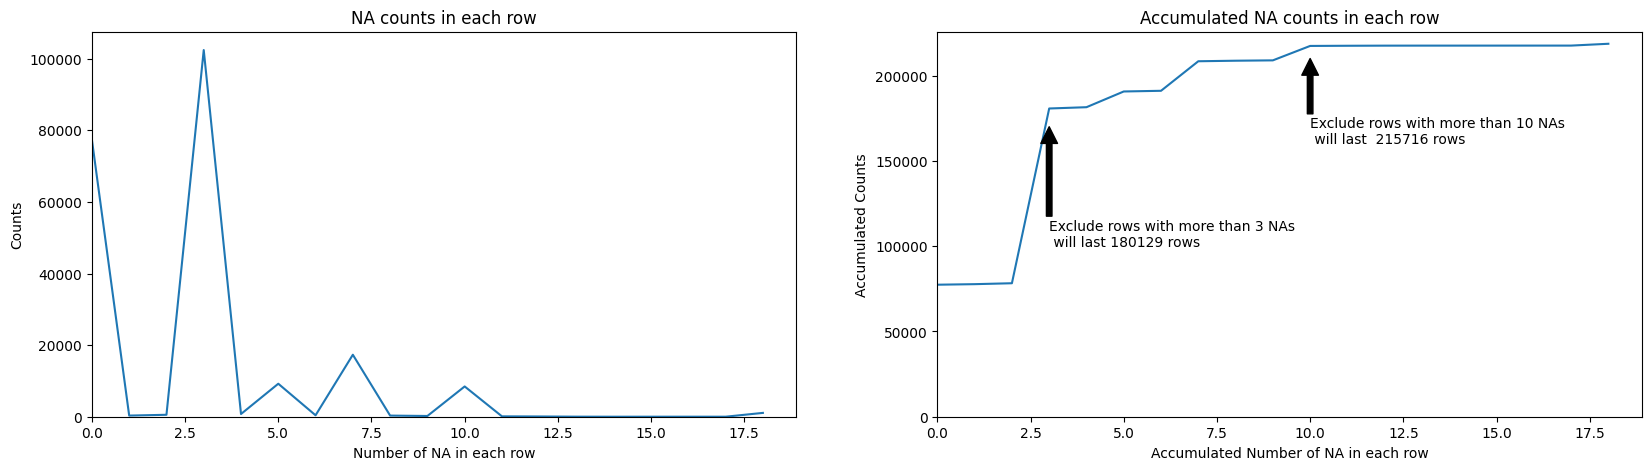

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('NA counts in each row')
plt.plot(data.isna().sum(axis=1).value_counts().sort_index())
plt.xlabel('Number of NA in each row')
plt.ylabel('Counts')
plt.xlim(0)
plt.ylim(0)

plt.subplot(1,2,2)
plt.title('Accumulated NA counts in each row')
plt.plot(data.isna().sum(axis=1).value_counts().sort_index().cumsum())
plt.annotate('Exclude rows with more than 10 NAs \n will last  215716 rows', xy=(10, 210000), xytext=(10, 160000),fontsize='medium',
            arrowprops={'facecolor':'black','shrink':1.0})
plt.annotate('Exclude rows with more than 3 NAs \n will last 180129 rows', xy=(3, 170000), xytext=(3, 100000),fontsize='medium',
            arrowprops={'facecolor':'black','shrink':1.0})
plt.xlabel('Accumulated Number of NA in each row')
plt.ylabel('Accumulated Counts')
plt.xlim(0)
_= plt.ylim(0)

In [11]:
data = data.dropna(thresh=17) # 17 = len(data.columns) - 3

In [12]:
def numeric(row):
    try:
        if np.isnan(row):
            return
        else:
            row =str(row)
            return float(row.replace('x','').replace('#','').replace('*',''))
    except TypeError:
        row =str(row)
        return float(row.replace('x','').replace('#','').replace('*',''))

In [13]:
data['WS_HR'] = data['WS_HR'].apply(numeric)
print(data['WS_HR'].describe())
print('\nThe skewness:',data['WS_HR'].skew())
print('Right skewed') if data['WS_HR'].skew()>0 else print('Left skewed')

count    180695.000000
mean          1.986593
std           1.725249
min           0.000000
25%           0.800000
50%           1.500000
75%           2.700000
max          50.000000
Name: WS_HR, dtype: float64

The skewness: 4.006735960393911
Right skewed


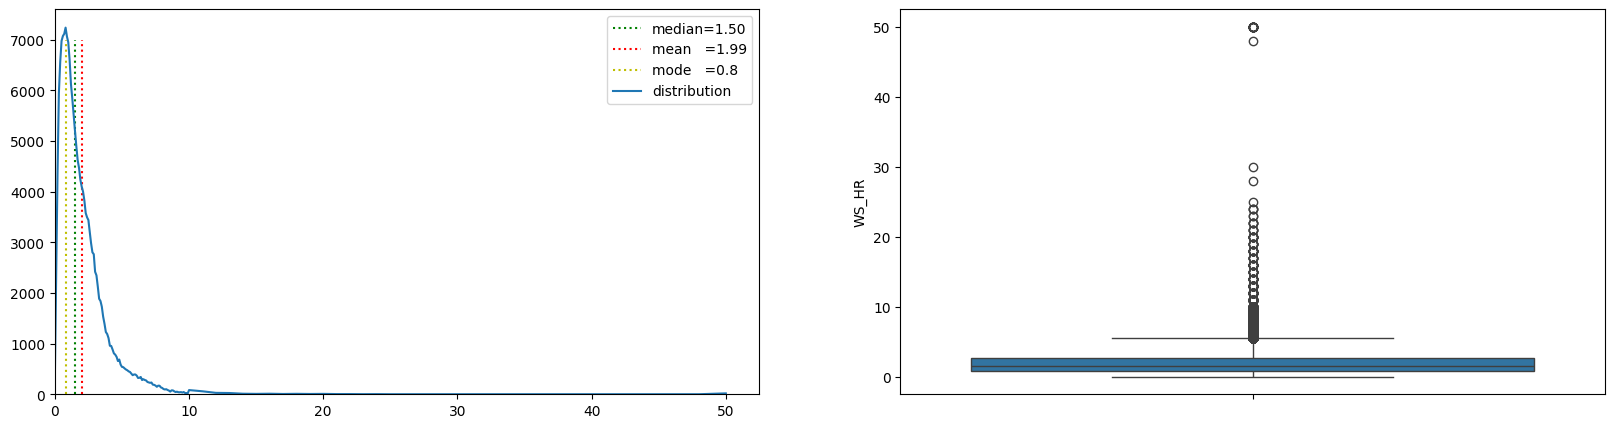

In [14]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot([data['WS_HR'].median(),data['WS_HR'].median()],[0,7000],'g:',label='median={0:.2f}'.format(data['WS_HR'].median()))
plt.plot([data['WS_HR'].mean(),data['WS_HR'].mean()],[0,7000],'r:',label='mean   ={0:.2f}'.format(data['WS_HR'].mean()))
plt.plot([data['WS_HR'].mode(),data['WS_HR'].mode()],[0,7000],'y:',label='mode   ={}'.format(data['WS_HR'].mode()[0]))
plt.plot(data['WS_HR'].value_counts().sort_index(),label='distribution')
plt.legend(loc='upper right')
plt.xlim(0)
plt.ylim(0)
plt.subplot(1,2,2)
_=sns.boxplot(data['WS_HR'])

In [15]:
data['WS_HR'].fillna(value=data['WS_HR'].median(),inplace=True)

In [16]:
for col in ['NO2','NO','NOx','PM10','CO','O3','AMB_TEMP','SO2','WD_HR','RH','WIND_DIREC', 'WIND_SPEED','PM2.5']:
    data[col]=data[col].apply(numeric)
    data[col].fillna(value=data[col].median(),inplace=True)
data['RAINFALL'] = data['RAINFALL'].apply(lambda x:0 if x=='NR' else x).apply(numeric)

In [17]:
print((data['CH4'].notna() & data['NMHC'].notna() & data['THC'].isna()).value_counts())
print('\n')
print(data['THC'].apply(numeric).describe())
print('\nMode :',data['THC'].apply(numeric).mode())
print('\nKurtosis is ',data['THC'].apply(numeric).kurt(),'>3, it is leptokurtic')

False    180696
Name: count, dtype: int64


count    78370.000000
mean         2.120940
std          0.343038
min         -0.300000
25%          1.900000
50%          2.100000
75%          2.200000
max         20.000000
Name: THC, dtype: float64

Mode : 0    2.0
Name: THC, dtype: float64

Kurtosis is  106.91703457719993 >3, it is leptokurtic


<Axes: ylabel='count'>

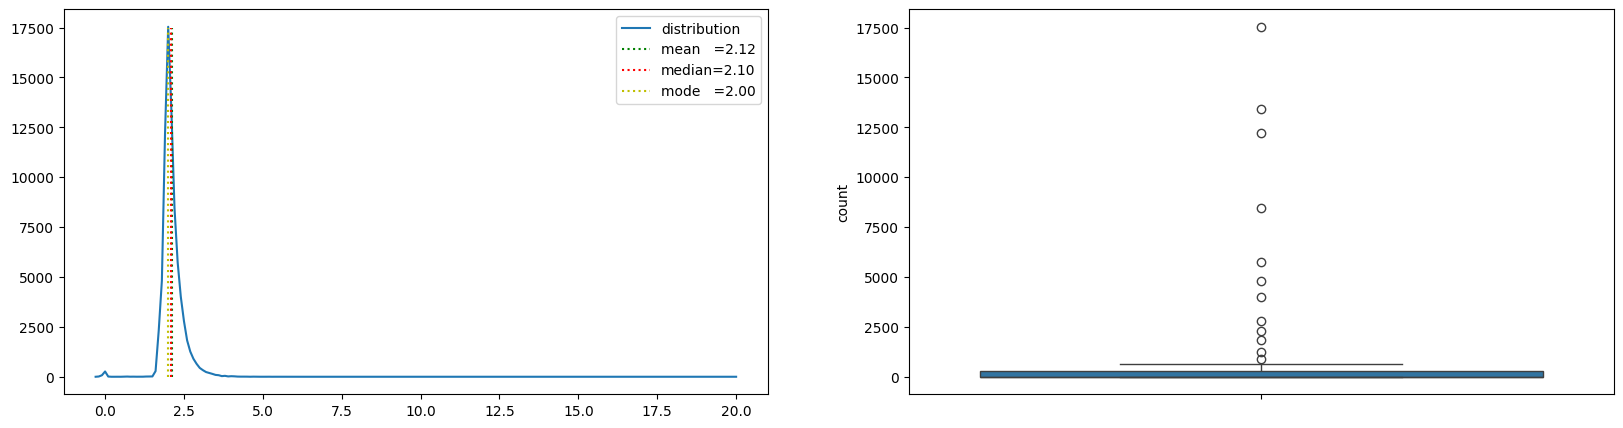

In [18]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(data['THC'].apply(numeric).value_counts().sort_index(),label='distribution')
plt.plot([data['THC'].apply(numeric).mean()]*2,[0,17500],'g:',label='mean   ={0:.2f}'.format(data['THC'].apply(numeric).mean()))
plt.plot([data['THC'].apply(numeric).median()]*2,[0,17500],'r:',label='median={0:.2f}'.format(data['THC'].apply(numeric).median()))
plt.plot([data['THC'].apply(numeric).mode()[0]]*2,[0,17500],'y:',label='mode   ={0:.2f}'.format(data['THC'].apply(numeric).mode()[0]))
plt.legend()

plt.subplot(1,2,2)
sns.boxplot(data['THC'].apply(numeric).value_counts().sort_index())

In [19]:
data.drop(['CH4','NMHC','THC'],axis=1,inplace=True)

In [20]:
data['year'] = pd.to_datetime(data['time']).dt.year
data['month'] = pd.to_datetime(data['time']).dt.month
data['day'] = pd.to_datetime(data['time']).dt.day
data['hour'] = pd.to_datetime(data['time']).dt.hour
# data.drop('time',axis=1,inplace=True)

In [21]:
continous_columns=['AMB_TEMP', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5', 'RAINFALL','RH', 'SO2', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED', 'WS_HR']
discrete_columns=['station','year','month','day','hour']

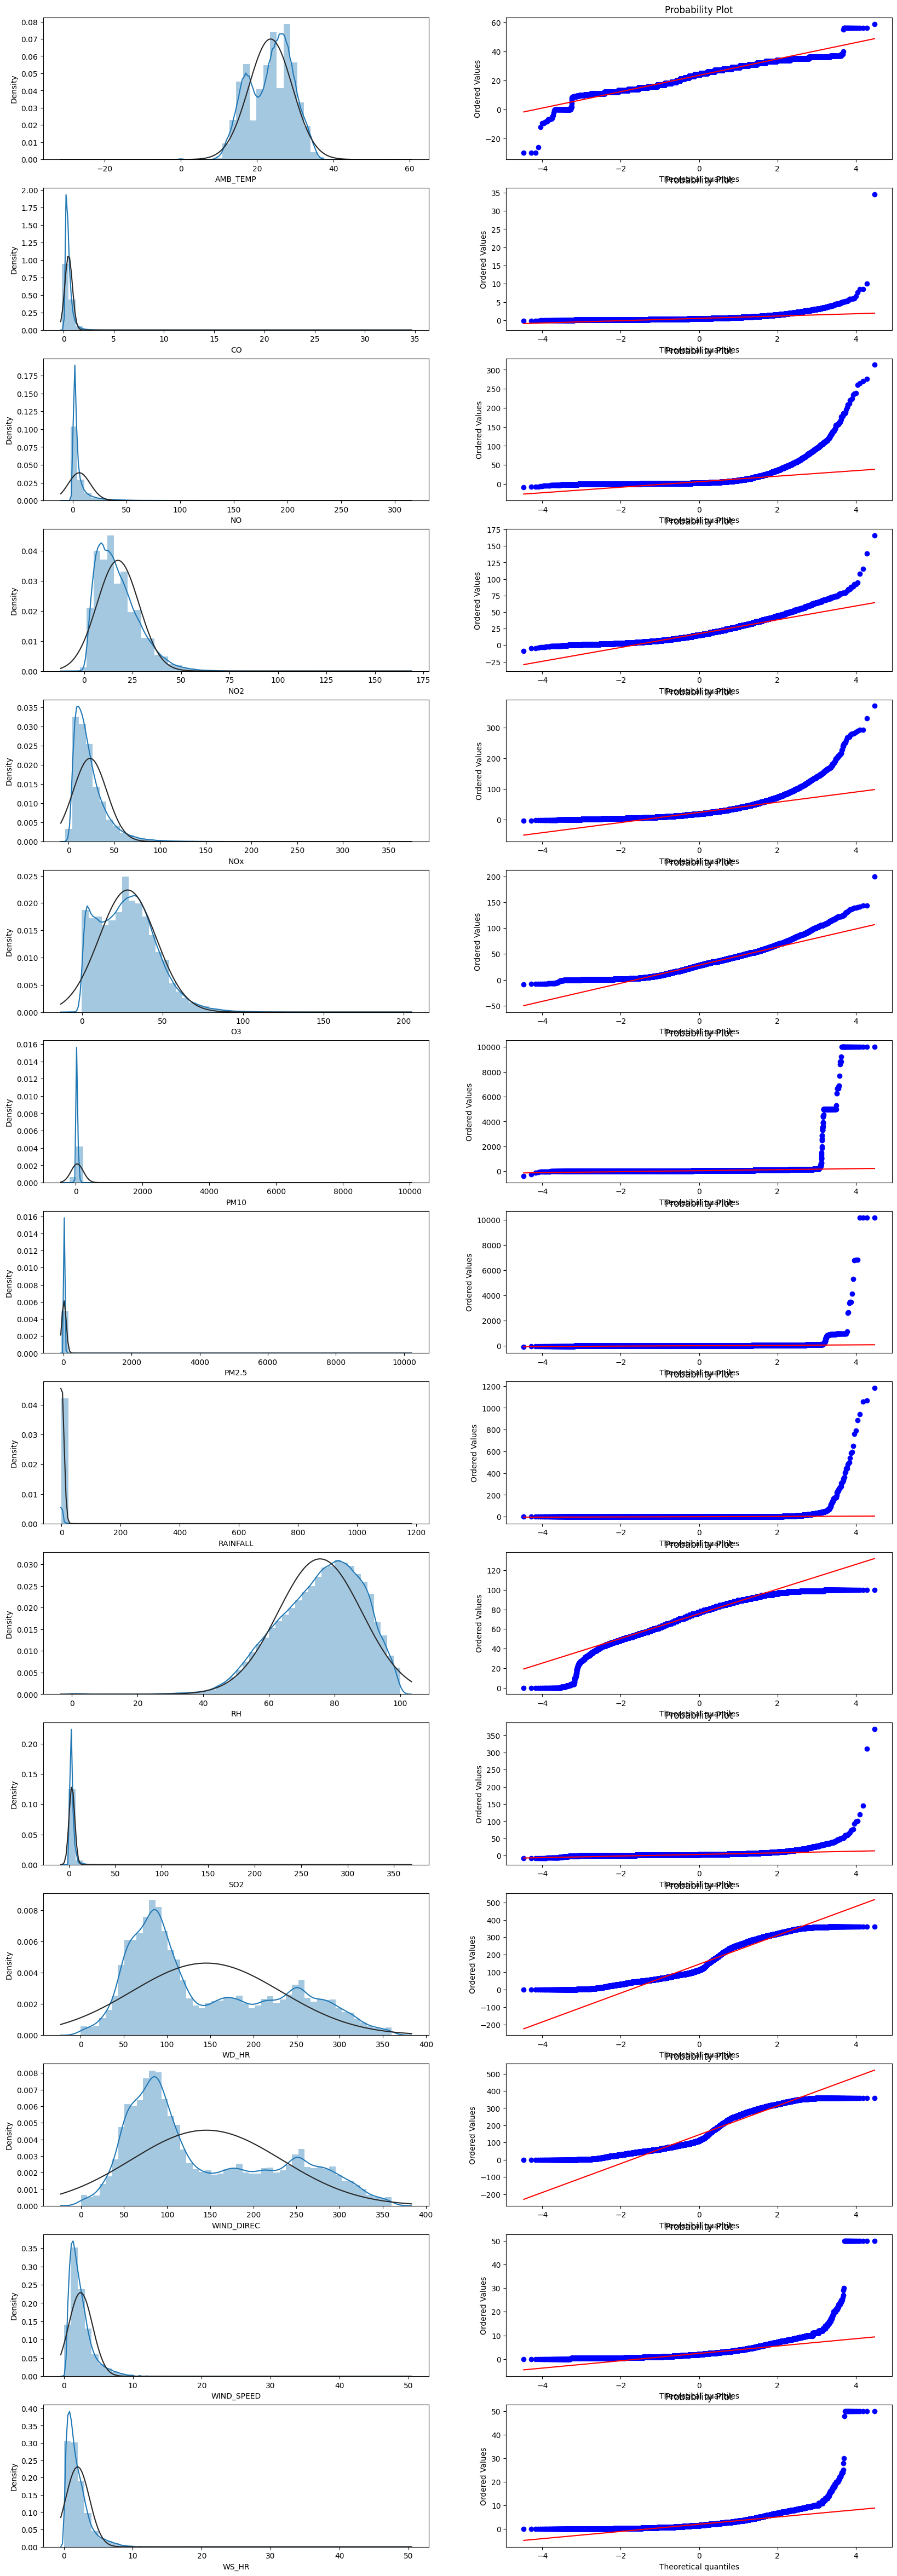

In [22]:
plt.figure(figsize=(20,60))
for number,col in enumerate(continous_columns):
    plt.subplot(15,2,number*2+1)
    sns.distplot(data[col],fit=norm)
    plt.subplot(15,2,number*2+2)
    res = stats.probplot(data[col],plot=plt)

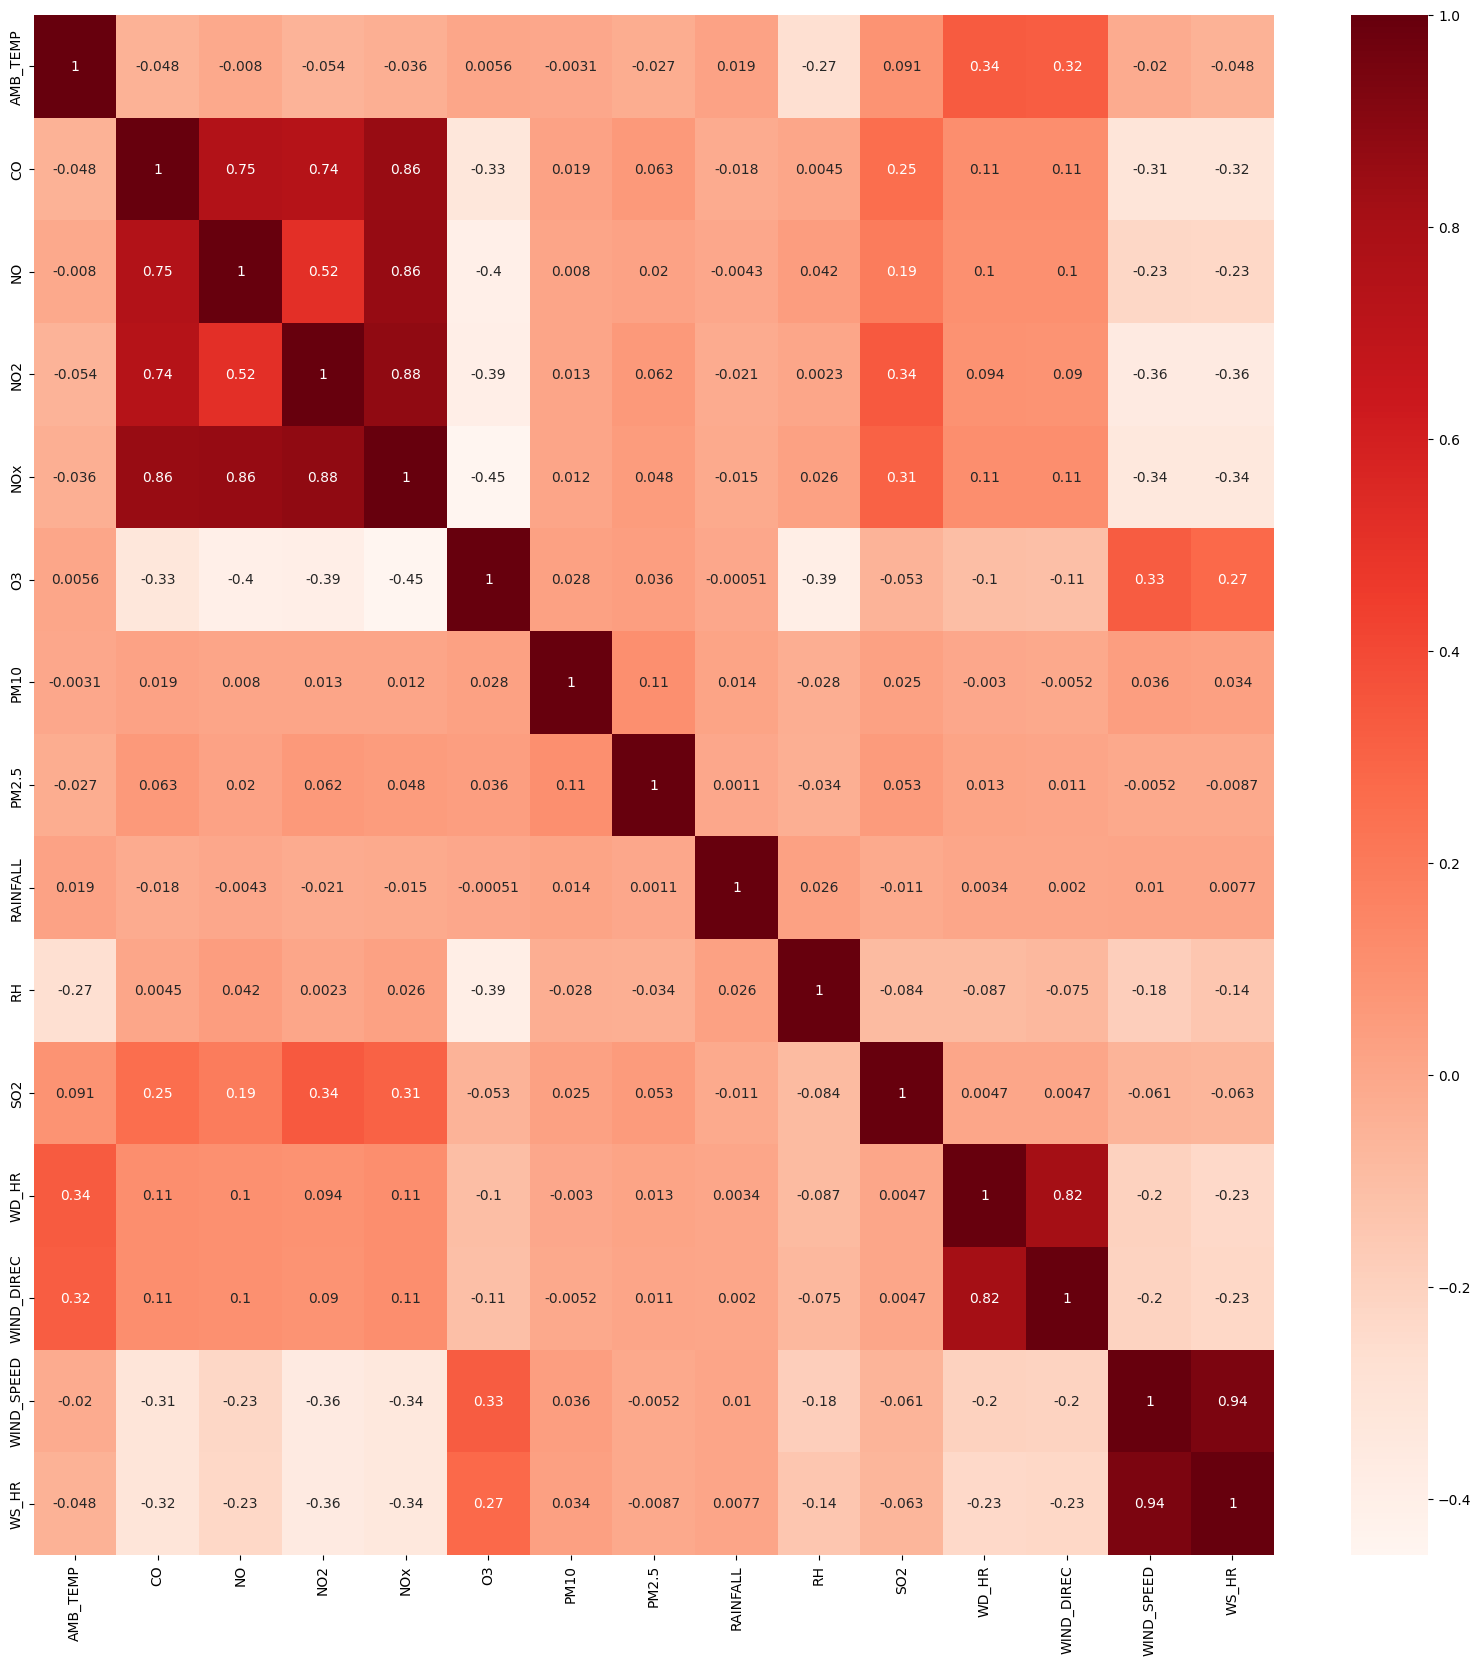

In [23]:
plt.figure(figsize=(20,20))
hm=sns.heatmap(data[continous_columns].corr().values,annot=True,
               xticklabels=continous_columns,
               yticklabels=continous_columns,
               cmap='Reds')

In [24]:
abs(data[continous_columns].corr()['PM2.5']).sort_values(ascending=False) # absolute number

PM2.5         1.000000
PM10          0.105224
CO            0.063188
NO2           0.061817
SO2           0.052612
NOx           0.047755
O3            0.035802
RH            0.033840
AMB_TEMP      0.026631
NO            0.020305
WD_HR         0.013161
WIND_DIREC    0.011264
WS_HR         0.008745
WIND_SPEED    0.005179
RAINFALL      0.001079
Name: PM2.5, dtype: float64

In [25]:
#we are taking Banqiao station for model building example.
data_Banqiao = data[data['station']=='Banqiao'].sort_values(by=['year','month','day','hour'])

In [26]:
for col in ['AMB_TEMP', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10','RAINFALL', 'RH', 'SO2', 'WD_HR']:
    stdscl = StandardScaler()
    data_Banqiao[col] = stdscl.fit_transform(data_Banqiao[col].values.reshape(-1,1))

In [27]:
data_Banqiao

,time,station,AMB_TEMP,CO,NO,NO2,NOx,O3,PM10,PM2.5,...,RH,SO2,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR,year,month,day,hour
0,2015-01-01 00:00:00,Banqiao,-1.419197,0.612980,-0.559538,-0.571413,-0.664331,0.541123,1.666312,78.0,...,-1.162117,3.049580,-0.830654,69.0,4.7,4.2,2015,1,1,0
1,2015-01-01 01:00:00,Banqiao,-1.419197,0.642171,-0.548057,-0.571413,-0.664331,0.489667,1.678973,77.0,...,-1.162117,2.682044,-0.852280,65.0,4.0,4.0,2015,1,1,1
2,2015-01-01 02:00:00,Banqiao,-1.419197,0.379451,-0.582499,-0.860182,-0.846881,0.592578,1.489060,72.0,...,-1.162117,1.579437,-0.895532,53.0,3.7,3.5,2015,1,1,2
3,2015-01-01 03:00:00,Banqiao,-1.593891,0.233496,-0.605461,-1.052695,-0.968580,0.644034,1.286486,65.0,...,-1.078531,1.028133,-0.895532,63.0,4.1,3.3,2015,1,1,3
4,2015-01-01 04:00:00,Banqiao,-1.593891,-0.145989,-0.628423,-1.148951,-1.029430,0.592578,1.083913,56.0,...,-1.078531,0.660598,-0.830654,67.0,3.0,3.1,2015,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2015-12-31 19:00:00,Banqiao,-1.244504,1.342759,-0.238074,1.449970,0.796067,0.386755,0.982626,67.0,...,-0.827773,1.211901,-0.646833,87.0,1.6,2.1,2015,12,31,19
8756,2015-12-31 20:00:00,Banqiao,-1.244504,0.846509,-0.341402,0.776175,0.309268,0.695490,0.944643,70.0,...,-0.744187,1.028133,-0.668459,82.0,2.0,1.7,2015,12,31,20
8757,2015-12-31 21:00:00,Banqiao,-1.244504,0.612980,-0.375844,0.294894,0.005018,0.644034,0.957304,70.0,...,-0.493430,0.182801,-0.646833,86.0,2.3,1.6,2015,12,31,21
8758,2015-12-31 22:00:00,Banqiao,-1.244504,0.612980,-0.364364,0.294894,0.005018,0.386755,0.868678,67.0,...,-0.409844,-0.147981,-0.668459,67.0,1.6,1.0,2015,12,31,22


In [28]:
import pandas as pd

# Assuming data_Banqiao is your DataFrame

# Drop rows with missing values
data_Banqiao.dropna(inplace=True)

# Shift the 'PM2.5' column to create the 'next_hour_pm2.5' column
data_Banqiao['next_hour_pm2.5'] = data_Banqiao['PM2.5'].shift(-1)

# Drop the last row (since shifting introduces NaN in the last row)
data_Banqiao.drop(data_Banqiao.index[-1], inplace=True)

# Split the data into training and testing sets based on the 'month' column
train_data = data_Banqiao[data_Banqiao['month'] != 12]
test_data = data_Banqiao[data_Banqiao['month'] == 12]

# Extract features and target for training set
y_train = train_data['next_hour_pm2.5'].values
x_train = train_data.loc[:, 'AMB_TEMP':'hour'].values

# Extract features and target for testing set
y_test = test_data['next_hour_pm2.5'].values
x_test = test_data.loc[:, 'AMB_TEMP':'hour'].values
x_train

array([[-1.4191974 ,  0.61298034, -0.55953765, ...,  1.        ,
         1.        ,  0.        ],
       [-1.4191974 ,  0.64217147, -0.54805682, ...,  1.        ,
         1.        ,  1.        ],
       [-1.4191974 ,  0.37945131, -0.58249932, ...,  1.        ,
         1.        ,  2.        ],
       ...,
       [-0.54573023, -0.17518015, -0.4332485 , ..., 11.        ,
        30.        , 21.        ],
       [-0.54573023, -0.23356241, -0.50213349, ..., 11.        ,
        30.        , 22.        ],
       [-0.54573023, -0.6130471 , -0.55953765, ..., 11.        ,
        30.        , 23.        ]])

In [29]:
# Need to check if it's suitable, because it will interrupt the continuity of time, e.g. is it proper to use time T+1 and Time T-1 to predirct Time T? Maybe not, but grid search is doing so. Therefore, I think maybe it's not fair to compare this RF to LSTM.
g_search = GridSearchCV(RandomForestRegressor(n_jobs=-1),param_grid={'n_estimators':[5,10,20],'max_features':[5,10],'max_depth':[10,20,30]},scoring='neg_mean_squared_error',n_jobs=-1,cv=2)
g_search.fit(x_train,y_train)
y_rf_pred = g_search.best_estimator_.predict(x_test)
pd.DataFrame(g_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.071472,0.008958,0.017247,0.002997,10,5,5,"{'max_depth': 10, 'max_features': 5, 'n_estima...",-387.580276,-26.989103,-207.284690,180.295587,2
1,0.123754,0.009657,0.014130,0.000209,10,5,10,"{'max_depth': 10, 'max_features': 5, 'n_estima...",-378.264058,-127.889393,-253.076726,125.187332,17
2,0.294892,0.003914,0.028188,0.000821,10,5,20,"{'max_depth': 10, 'max_features': 5, 'n_estima...",-377.824008,-62.073140,-219.948574,157.875434,10
3,0.159251,0.022177,0.035678,0.000722,10,10,5,"{'max_depth': 10, 'max_features': 10, 'n_estim...",-377.858428,-150.512064,-264.185246,113.673182,18
4,0.289991,0.049330,0.030792,0.013267,10,10,10,"{'max_depth': 10, 'max_features': 10, 'n_estim...",-373.281918,-82.389533,-227.835725,145.446192,15
5,0.824231,0.000749,0.034333,0.008658,10,10,20,"{'max_depth': 10, 'max_features': 10, 'n_estim...",-374.822867,-44.929028,-209.875948,164.946919,4
6,0.174639,0.061846,0.022457,0.008505,20,5,5,"{'max_depth': 20, 'max_features': 5, 'n_estima...",-390.951346,-62.432368,-226.691857,164.259489,14
7,0.328535,0.010551,0.043756,0.006163,20,5,10,"{'max_depth': 20, 'max_features': 5, 'n_estima...",-384.195677,-56.993115,-220.594396,163.601281,12
8,0.604057,0.014133,0.053020,0.001817,20,5,20,"{'max_depth': 20, 'max_features': 5, 'n_estima...",-379.094387,-43.410569,-211.252478,167.841909,5
9,0.270904,0.023429,0.045594,0.005199,20,10,5,"{'max_depth': 20, 'max_features': 10, 'n_estim...",-374.358778,-52.379012,-213.368895,160.989883,8


MSE 247.15586278517182


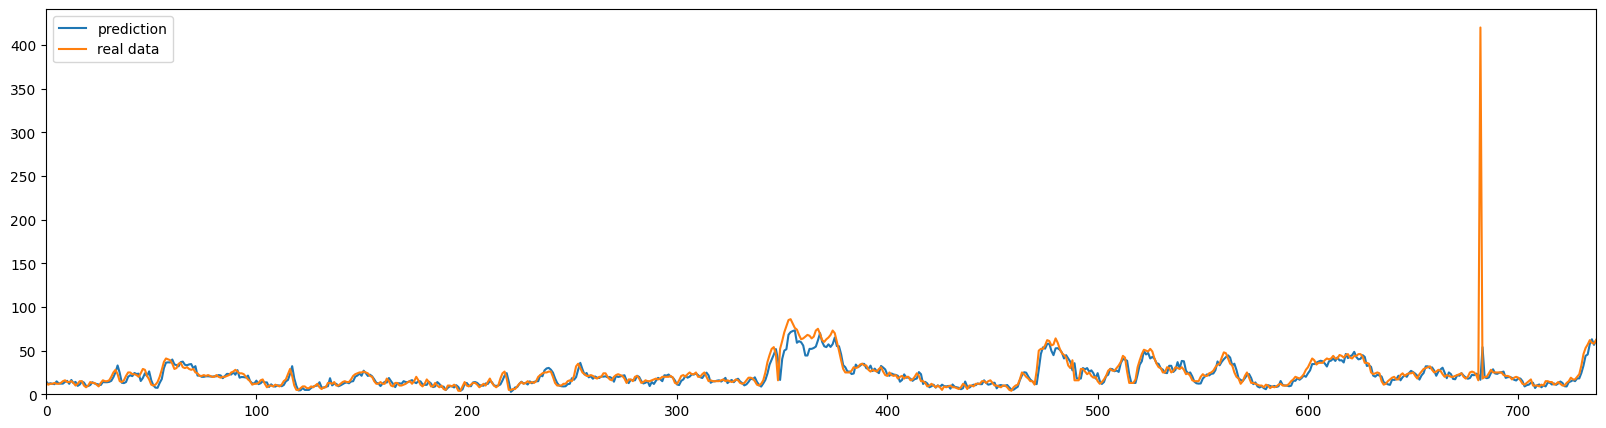

In [30]:
plt.figure(figsize=(20,5))
plt.plot(y_rf_pred,label='prediction')
plt.plot(y_test,label='real data')
plt.xlim(0,737)
plt.ylim(0,)
_ =plt.legend(loc='upper left')
print('MSE',mean_squared_error(y_test, y_rf_pred))